In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/arithmetic-prompt-dataset/arithmetic_prompt_dataset.csv


In [2]:
NEURONPEDIA_KEY = ""
MARTIAN_KEY = ""

In [12]:
import requests
import time
import logging
from typing import List, Optional, Dict, Any

# Set up logging
logging.basicConfig(level=logging.INFO)
logger = logging.getLogger(__name__)

def search_neuronpedia(
    text: str,
    model_id: str = "gpt2-small",
    source_set: str = "res-jb",
    selected_layers: Optional[List[str]] = [],
    sort_indexes: Optional[List[int]] = [],
    ignore_bos: bool = False,
    density_threshold: int = -1,
    num_results: int = 10,
    max_retries: int = 5,
    retry_delay: float = 2.0,
    backoff_factor: float = 2.0
) -> Dict[Any, Any]:
    """
    Search Neuronpedia for explanations of neural network activations with retry logic.
    
    Args:
        text (str): The input text to analyze
        model_id (str): Model identifier (default: "gpt2-small")
        source_set (str): Source set identifier (default: "res-jb")
        selected_layers (List[str], optional): Layers to analyze (default: [])
        sort_indexes (List[int], optional): Sort indexes (default: [])
        ignore_bos (bool): Whether to ignore beginning of sequence token (default: False)
        density_threshold (int): Density threshold for filtering (default: -1)
        num_results (int): Number of results to return (default: 10)
        max_retries (int): Maximum number of retry attempts (default: 5)
        retry_delay (float): Initial delay between retries in seconds (default: 2.0)
        backoff_factor (float): Multiplier for exponential backoff (default: 2.0)
    
    Returns:
        Dict: JSON response from Neuronpedia API containing explanations
    
    Raises:
        requests.RequestException: If all retry attempts fail
    """
    
    url = "https://www.neuronpedia.org/api/explanation/search-model"
    
    headers = {
        "Content-Type": "application/json",
        "X-Api-Key": NEURONPEDIA_KEY  # Make sure NEURONPEDIA_KEY is defined
    }
    
    payload = {
        "modelId": model_id,
        "query": text,
    }
    
    for attempt in range(max_retries + 1):
        try:
            logger.info(f"Attempting Neuronpedia request (attempt {attempt + 1}/{max_retries + 1})")
            response = requests.post(url, headers=headers, json=payload, timeout=30)
            response.raise_for_status()
            logger.info("Neuronpedia request successful")
            return response.json()
            
        except requests.exceptions.HTTPError as e:
            if response.status_code == 500:
                if attempt < max_retries:
                    delay = retry_delay * (backoff_factor ** attempt)
                    logger.warning(f"500 Server Error from Neuronpedia. Retrying in {delay:.1f} seconds... (attempt {attempt + 1}/{max_retries + 1})")
                    time.sleep(delay)
                    continue
                else:
                    logger.error(f"Max retries ({max_retries}) exceeded for Neuronpedia 500 errors")
                    raise
            else:
                # For non-500 errors, don't retry
                logger.error(f"Non-retryable HTTP error from Neuronpedia: {e}")
                raise
                
        except (requests.exceptions.RequestException, requests.exceptions.Timeout) as e:
            if attempt < max_retries:
                delay = retry_delay * (backoff_factor ** attempt)
                logger.warning(f"Request error to Neuronpedia: {e}. Retrying in {delay:.1f} seconds... (attempt {attempt + 1}/{max_retries + 1})")
                time.sleep(delay)
                continue
            else:
                logger.error(f"Max retries ({max_retries}) exceeded for Neuronpedia request errors")
                raise
    
    # This should never be reached, but just in case
    raise requests.RequestException("Unexpected error: max retries exceeded")

In [23]:
def create_judge_prompt(
    operation: str,
    ground_truth: str,
    llm_responses: list,  # List of dicts with keys: 'model_name', 'response', 'top_features'
) -> str:
    """
    Create a parameterized prompt for an LLM judge to evaluate mathematical operation responses.
    
    Args:
        operation (str): The mathematical operation being evaluated (e.g., "addition", "multiplication", "subtraction")
        ground_truth (str): The correct answer for the mathematical operation
        llm_responses (list): List of dictionaries containing:
            - 'model_name': Name of the LLM model
            - 'response': The model's response to the mathematical operation
            - 'top_features': List of features that were most activated in this model
    
    Returns:
        str: Formatted prompt for the judge LLM
    """
    
    # Build the responses section
    responses_section = ""
    for i, resp in enumerate(llm_responses, 1):
        features_str = ", ".join(resp['top_features'])
        responses_section += f"""
Response {i}: Model Name - {resp['model_name']}:
Answer: {resp['response']}
Top Activated Features: {features_str}
"""
    
   prompt = f"""You are an expert LLM evaluator tasked with judging mathematical operation responses.

TASK: Evaluate which LLM response is most accurate and best conforms to the expected features for {operation} operations.

OPERATION: {operation}
GROUND TRUTH: {ground_truth}

LLM RESPONSES:
{responses_section}

EVALUATION CRITERIA:
1. ACCURACY: Which response exactly matches the ground truth answer?
2. FEATURE CONFORMITY: Which model's activated features are most appropriate for {operation} operations?

For {operation} operations, relevant features typically include (Feel free to include any other indicative features):
- Mathematical reasoning capabilities
- Arithmetic computation features  
- Numerical processing components
- Pattern recognition for {operation}

INSTRUCTIONS:
1. Compare each response against the ground truth
2. Evaluate how well each model's activated features align with {operation} operations
3. Determine which model performed best overall considering both accuracy and feature appropriateness (If None of them got the correct answer, return None)

CRITICAL: You MUST respond with ONLY the specified format. No explanations, no additional text, no reasoning.

REQUIRED OUTPUT FORMAT:
Provide your final judgment in exactly this format (no additional text):

(model_name, conformed_features)

STRICT REQUIREMENTS:
- model_name: EXACTLY one of the provided model names OR "None" - NO OTHER TEXT ALLOWED
- conformed_features: Comma-separated list of the most relevant Top Activated Features from that model for {operation} operation
- brief_grading_note: Provide brief explaination for the grading 
- Use parentheses, not curly braces
- No explanations or additional commentary

Valid model names from responses: {', '.join([resp['model_name'] for resp in llm_responses])}

Example output format: (gemma-2-27b-it, arithmetic_reasoning, numerical_computation, mathematical_logic, gemma-2-27b-it had numerical features that closely align with the operation than claude-sonnet-3-5)
Example if none correct: (None, None of the models used the required features)

RESPOND WITH ONLY THE FORMAT ABOVE - NO OTHER TEXT."""

    return prompt

IndentationError: unindent does not match any outer indentation level (<tokenize>, line 31)

In [5]:
def judge_baseline(responses, result, operation, judge_model):
    eval_query = create_judge_prompt(operation, result, responses)
    response = chat_with_martian(eval_query, judge_model)
    return response 

In [ ]:
# def router_query(query, models)

In [6]:
from typing import List, Dict, Any, Union

def chat_with_martian(
    query: Union[str, List[Dict[str, str]]],
    model: str = "gpt-3.5-turbo",
    models: list = [],
    temperature: float = 1.0,
) -> Dict[Any, Any]:
    """
    Send a chat completion request to Martian API.
    
    Args:
        query (str or List[Dict]): Either a simple string query or a list of message dicts
                                  If string, it will be converted to a user message
        model (str): Model to use (default: "gpt-3.5-turbo")
        temperature (float): Sampling temperature (default: 1.0)
        api_key (str): Your Martian API key (required)
    
    Returns:
        Dict: JSON response from Martian API
    
    Raises:
        ValueError: If api_key is not provided
        requests.RequestException: If the API request fails
    """
    
    if MARTIAN_KEY is None:
        raise ValueError("API key is required. Please provide your Martian API key.")
    
    url = "https://withmartian.com/api/openai/v2/chat/completions"
    
    headers = {
        "Content-Type": "application/json",
        "Authorization": f"Bearer {MARTIAN_KEY}"
    }
    
    # Convert query to messages format
    if isinstance(query, str):
        messages = [{"role": "user", "content": query}]
    elif isinstance(query, list):
        messages = query
    else:
        raise ValueError("Query must be either a string or a list of message dictionaries")
    
    payload = {
        "model": model,
        "messages": messages,
        "temperature": temperature
    }
    # add candidate models if in route config 
    if model == "router": 
        payload["models"] = models 
    try:
        response = requests.post(url, headers=headers, json=payload)
        response.raise_for_status()  # Raises an HTTPError for bad responses
        return response.json()
    except requests.RequestException as e:
        print(f"Error making request to Martian API: {e}")
        raise

In [7]:
import pandas as pd 
dataset = pd.read_csv("/kaggle/input/arithmetic-prompt-dataset/arithmetic_prompt_dataset.csv")
dataset

,prompt,x,y,label
0,What is 2 minus 15?,2,15,subtract
1,What do you get when you add 44 to 3?,44,3,add
2,A car travels 82 kilometers every hour. How fa...,82,36,multiply
3,Calculate 44 multiplied by 98.,44,98,multiply
4,What is 38 minus 28?,38,28,subtract
...,...,...,...,...
295,Give me the total of 49 and 77.,49,77,add
296,What do you get if you times 54 and 53?,54,53,multiply
297,"If each of the 95 boxes contains 22 candies, h...",95,22,multiply
298,Add 12 and 28.,12,28,add


In [8]:
from sklearn.model_selection import train_test_split
train,test = train_test_split(dataset, test_size = 0.3, stratify = dataset["label"])

In [9]:
len(test)

90

In [10]:
def get_result(x, y, opn): 
    if opn == "add": 
        return x+y
    if opn == "subtract":
        return x-y
    if opn == "multiply": 
        return x*y
    return x+y

In [ ]:
evals = []

In [35]:
import time
candidate_models = [("together/google/gemma-2-27b-it", "gemma-2-9b-it"), ("together/deepseek-ai/DeepSeek-R1", 'deepseek-r1-distill-llama-8b')]
no_of_features = 10
judge_model = "anthropic/anthropic/claude-3-5-sonnet-latest"

for i, row in test.iloc[88:].iterrows(): 
    query = row['prompt']
    x,y,opn = row["x"], row["y"], row["label"]
    result = get_result(x,y,opn)
    responses = []
    for model in candidate_models: 
        res = {}
        res['model_name'] = model[0] 
        res['response'] = chat_with_martian(query, model[0])['response']['content']
        res['top_features'] = [k['description'] for k in search_neuronpedia(query, model[1])['results']][:no_of_features]
        responses.append(res)   
        # time.sleep(10)
    evaluation = judge_baseline(responses, result, opn, judge_model=judge_model)
    print(evaluation)
    evals.append(evaluation)

{'id': '4c35c381-8399-4906-bda9-a5f55fcc44a5', 'choices': [{'finish_reason': 'stop', 'index': 0, 'logprobs': None, 'message': {'content': "together/google/gemma-2-27b-it, mathematical expressions involving subtraction, mathematical operations and terms related to subtraction, subtraction and negative values in mathematical expressions, negative numbers or expressions indicating subtraction\n\nReasoning (not part of output):\n1. Accuracy: Both models arrived at the correct answer of -13.\n2. Feature Conformity Analysis:\n- Gemma's features are more concise and directly relevant to subtraction operations\n- DeepSeek's features are repetitive and less diverse\n- Gemma's features specifically mention negative values and different aspects of subtraction\n3. Overall: While both models got the correct answer, Gemma's feature set is more appropriate and focused for subtract operations.", 'refusal': None, 'role': 'assistant', 'annotations': None, 'audio': None, 'function_call': None, 'tool_call

In [36]:
len(evals)

90

In [45]:
df = pd.DataFrame()
evals[0]["response"]["content"].split(",")

['together/google/gemma-2-27b-it',
 ' numerical_values',
 ' instances_of_numbers',
 ' pattern_recognition_for_addition\n\nReasoning (not part of output):\n1. Accuracy: Both models arrived at correct answer 86\n2. Feature analysis:\n- Gemma showed cleaner focus on numerical recognition/values\n- DeepSeek had more verbose features with less focus on core arithmetic\n3. While both were accurate',
 " Gemma's features better aligned with add operation expectations by focusing on number recognition and numerical processing\n4. The output format matches exactly what's requested",
 ' with relevant features from winning model separated by commas\n\nNote: This explanatory text is just for transparency - only the one-line output above should be considered the actual response.']

In [65]:
all_split_content = [eval_entry["response"]["content"].split(",") for eval_entry in evals]
df = pd.DataFrame(all_split_content)

In [66]:
# Clean whitespace from split values
df = df.apply(lambda x: x.str.strip() if x.dtype == "object" else x)

# Name the columns
df.columns = [f'col_{i}' for i in range(len(df.columns))]
df

,col_0,col_1,col_2,col_3,col_4,col_5,col_6,col_7,col_8,col_9,col_10,col_11,col_12
0,together/google/gemma-2-27b-it,numerical_values,instances_of_numbers,pattern_recognition_for_addition\n\nReasoning ...,Gemma's features better aligned with add opera...,with relevant features from winning model sepa...,None,None,None,None,None,None,None
1,together/google/gemma-2-27b-it,mathematical operations involving products,numerical expressions involving multiplication...,mathematical operations and terms related to m...,mathematical operations and calculations relat...,None,None,None,None,None,None,None,None
2,After evaluating both responses:\n\nBoth model...,but their feature sets differ significantly.\n...,demonstrating:\n- Step-by-step subtraction log...,"both models' reported ""Top Activated Features""...",which isn't ideal for subtract operations.\n\n...,it performed better overall.\n\ntogether/deeps...,mathematical_reasoning,arithmetic_computation,numerical_processing,problem_decomposition,None,None,None
3,together/google/gemma-2-27b-it,mathematical operations and calculations invol...,negative numbers or expressions indicating sub...,mathematical expressions involving subtraction,mathematical expressions involving subtraction...,None,None,None,None,None,None,None,None
4,together/deepseek-ai/DeepSeek-R1,numbers inside of boxes,answers with numbers inside boxes,boxed numbers,mathematical fractions encased in boxes,values inside of boxes,None,None,None,None,None,None,None
...,...,...,...,...,...,...,...,...,...,...,...,...,...
85,together/google/gemma-2-27b-it,mathematical calculations and expressions,mathematical operations and calculations,mathematical expressions and numerical calcula...,focusing on core mathematical calculations and...,71) rather than general addition capabilities\...,for pure addition operations,Gemma's feature set is more appropriately alig...,None,None,None,None,None
86,together/google/gemma-2-27b-it,mathematical operations involving products,mathematical sums and products in equations,numerical expressions involving multiplication...,mathematical operations and expressions involv...,None,None,None,None,None,None,None,None
87,together/deepseek-ai/DeepSeek-R1,mathematical calculations with multiplication,multiplication involving the number 4 and math...,mathematical calculations involving multiplica...,calculations involving multiplication,mathematical formulas involving multiplication...,None,None,None,None,None,None,None
88,together/google/gemma-2-27b-it,mathematical expressions involving subtraction,mathematical operations and terms related to s...,subtraction and negative values in mathematica...,negative numbers or expressions indicating sub...,Gemma's feature set is more appropriate and fo...,None,None,None,None,None,None,None


In [48]:
df.to_csv("sae_based_judging.csv", index=False)

In [68]:
test["label"].reset_index(drop=True)

0          add
1     multiply
2     subtract
3     subtract
4     multiply
        ...   
85         add
86    multiply
87    multiply
88    subtract
89    subtract
Name: label, Length: 90, dtype: object

In [69]:
df["label"] = test["label"].reset_index(drop=True)
cleaned_df = df[(df["col_0"] == candidate_models[0][0]) |  (df["col_0"] == candidate_models[1][0]) | (df["col_0"] =="None")]
cleaned_df

,col_0,col_1,col_2,col_3,col_4,col_5,col_6,col_7,col_8,col_9,col_10,col_11,col_12,label
0,together/google/gemma-2-27b-it,numerical_values,instances_of_numbers,pattern_recognition_for_addition\n\nReasoning ...,Gemma's features better aligned with add opera...,with relevant features from winning model sepa...,None,None,None,None,None,None,None,add
1,together/google/gemma-2-27b-it,mathematical operations involving products,numerical expressions involving multiplication...,mathematical operations and terms related to m...,mathematical operations and calculations relat...,None,None,None,None,None,None,None,None,multiply
3,together/google/gemma-2-27b-it,mathematical operations and calculations invol...,negative numbers or expressions indicating sub...,mathematical expressions involving subtraction,mathematical expressions involving subtraction...,None,None,None,None,None,None,None,None,subtract
4,together/deepseek-ai/DeepSeek-R1,numbers inside of boxes,answers with numbers inside boxes,boxed numbers,mathematical fractions encased in boxes,values inside of boxes,None,None,None,None,None,None,None,multiply
5,together/google/gemma-2-27b-it,negative numbers or expressions indicating sub...,mathematical expressions involving subtraction,mathematical operations and calculations invol...,mathematical expressions involving addition an...,None,None,None,None,None,None,None,None,subtract
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
85,together/google/gemma-2-27b-it,mathematical calculations and expressions,mathematical operations and calculations,mathematical expressions and numerical calcula...,focusing on core mathematical calculations and...,71) rather than general addition capabilities\...,for pure addition operations,Gemma's feature set is more appropriately alig...,None,None,None,None,None,add
86,together/google/gemma-2-27b-it,mathematical operations involving products,mathematical sums and products in equations,numerical expressions involving multiplication...,mathematical operations and expressions involv...,None,None,None,None,None,None,None,None,multiply
87,together/deepseek-ai/DeepSeek-R1,mathematical calculations with multiplication,multiplication involving the number 4 and math...,mathematical calculations involving multiplica...,calculations involving multiplication,mathematical formulas involving multiplication...,None,None,None,None,None,None,None,multiply
88,together/google/gemma-2-27b-it,mathematical expressions involving subtraction,mathematical operations and terms related to s...,subtraction and negative values in mathematica...,negative numbers or expressions indicating sub...,Gemma's feature set is more appropriate and fo...,None,None,None,None,None,None,None,subtract


In [76]:
cleaned_df[["col_1", "col_2"]].value_counts()

col_1                                                                           col_2                                                                         
mathematical operations and calculations involving multiplication and division  mathematical operations involving products                                        4
mathematical expressions and operations involving addition                      mathematical operations involving addition                                        4
mathematical expressions involving subtraction                                  negative numbers or references to subtraction                                     3
mathematical operations and calculations involving multiplication and division  mathematical operations and expressions involving multiplication                  3
mathematical operations involving products                                      mathematical operations and terms related to multiplication                       2
                     

In [82]:
concepts = np.concatenate((cleaned_df['col_1'].values, cleaned_df['col_2'].values), axis = 0)

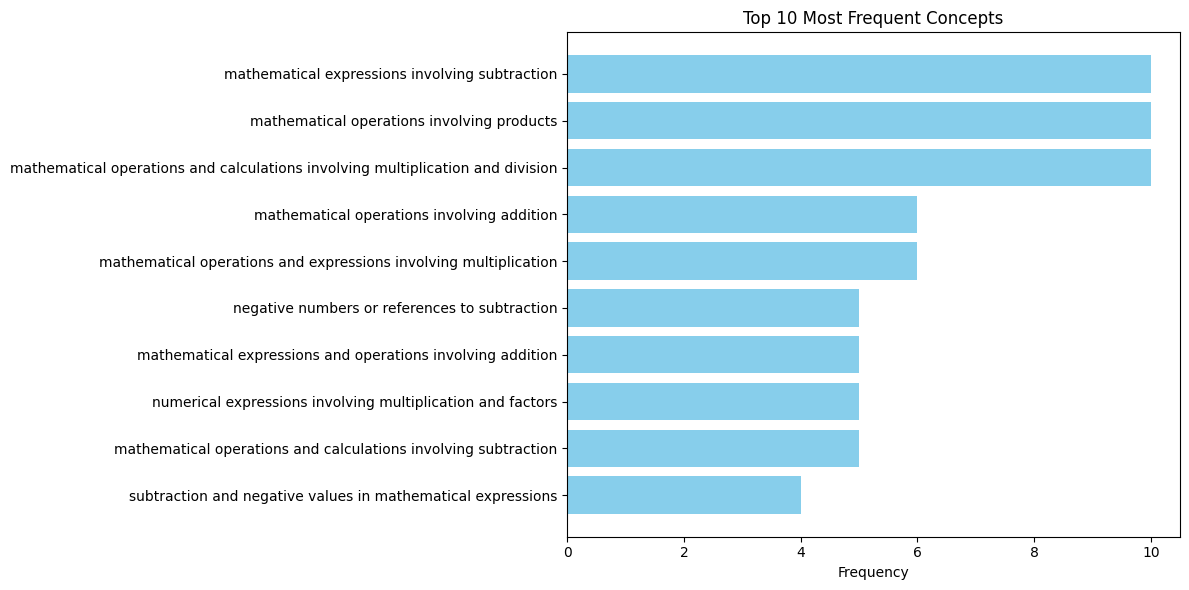

In [91]:
import numpy as np
import matplotlib.pyplot as plt
def plot_concepts(concepts):
# Count and sort
    unique, counts = np.unique(concepts, return_counts=True)
    sorted_indices = np.argsort(-counts)
    sorted_unique = unique[sorted_indices]
    sorted_counts = counts[sorted_indices]
    
    # Take top 10
    top_unique = sorted_unique[:10]
    top_counts = sorted_counts[:10]
    
    # Plot
    plt.figure(figsize=(12, 6))
    bars = plt.barh(range(len(top_unique)), top_counts, color='skyblue')
    plt.yticks(range(len(top_unique)), top_unique)
    plt.gca().invert_yaxis()  # Most frequent at the top
    
    # Labels and title
    plt.xlabel('Frequency')
    plt.title('Top 10 Most Frequent Concepts')
    plt.tight_layout()
    plt.show()
plot_concepts(concepts)

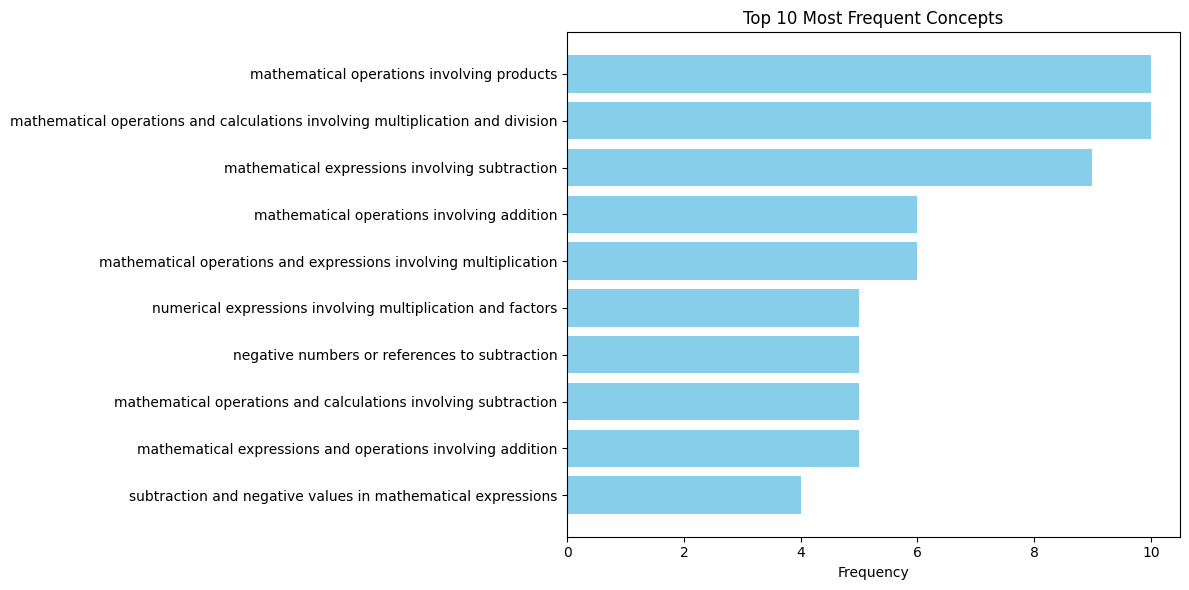

In [95]:
concepts_gemma = np.concatenate((cleaned_df[cleaned_df["col_0"] == "together/google/gemma-2-27b-it"]['col_1'].values, cleaned_df[cleaned_df["col_0"] == "together/google/gemma-2-27b-it"]['col_2'].values), axis = 0)
plot_concepts(concepts_gemma)

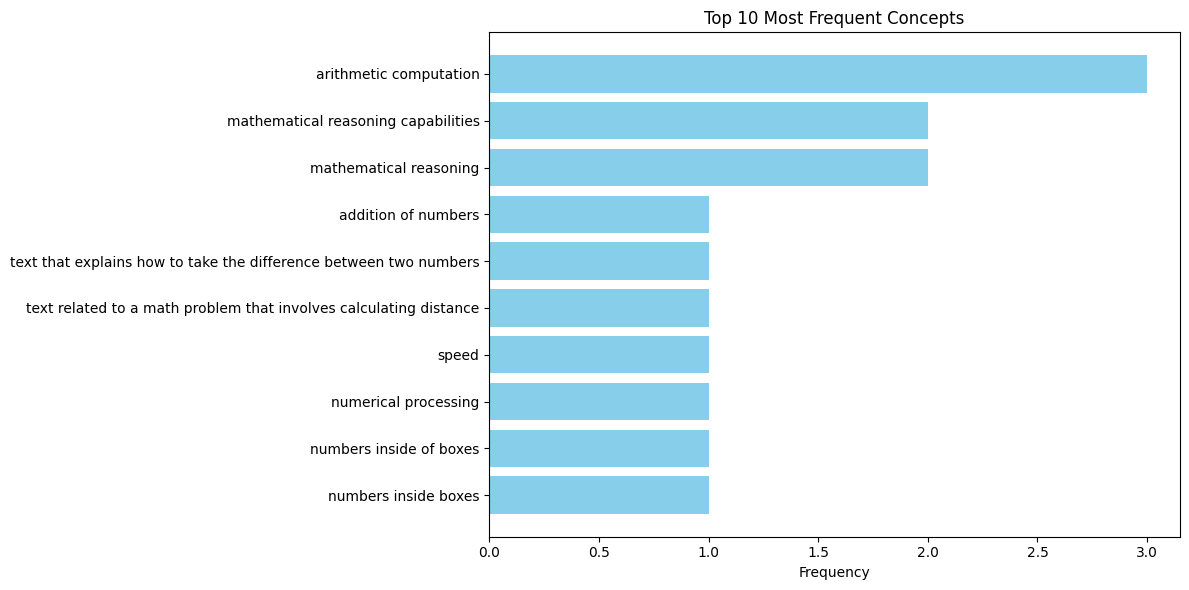

In [96]:
concepts_deepseek = np.concatenate((cleaned_df[cleaned_df["col_0"] == "together/deepseek-ai/DeepSeek-R1"]['col_1'].values, cleaned_df[cleaned_df["col_0"] == "together/deepseek-ai/DeepSeek-R1"]['col_2'].values), axis = 0)
plot_concepts(concepts_deepseek)

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

# Count and sort
unique, counts = np.unique(concepts, return_counts=True)
sorted_indices = np.argsort(-counts)
sorted_unique = unique[sorted_indices]
sorted_counts = counts[sorted_indices]

# Take top 10
top_unique = sorted_unique[:10]
top_counts = sorted_counts[:10]

# Plot
plt.figure(figsize=(12, 6))
bars = plt.barh(range(len(top_unique)), top_counts, color='skyblue')
plt.yticks(range(len(top_unique)), top_unique)
plt.gca().invert_yaxis()  # Most frequent at the top

# Labels and title
plt.xlabel('Frequency')
plt.title('Top 10 Most Frequent Concepts')
plt.tight_layout()
plt.show()


In [70]:
import matplotlib.pyplot as plt
def plot_model_counts_advanced(
    df: pd.DataFrame,
    label_col: str = 'label', 
    model_col: str = 'model',
    figsize: tuple = (15, 10),
    style: str = 'grouped'  # 'grouped', 'stacked', or 'side_by_side'
):
    """
    Advanced plotting function with multiple visualization styles.
    
    Args:
        df: DataFrame with data
        label_col: Column name for labels
        model_col: Column name for models  
        figsize: Figure size
        style: Plotting style ('grouped', 'stacked', 'side_by_side')
    
    Returns:
        matplotlib figure and axes
    """
    
    # Create crosstab for easier manipulation
    crosstab = pd.crosstab(df[label_col], df[model_col])
    
    if style == 'grouped':
        return plot_model_counts_by_label(df, label_col, model_col, figsize)
    
    elif style == 'stacked':
        fig, ax = plt.subplots(figsize=figsize)
        crosstab.plot(kind='bar', stacked=True, ax=ax, 
                     colormap='Set3', alpha=0.8, edgecolor='black')
        ax.set_title(f'Stacked Model Distribution by {label_col.title()}', 
                    fontsize=14, fontweight='bold')
        ax.set_xlabel(label_col.title(), fontsize=12)
        ax.set_ylabel('Count', fontsize=12)
        plt.xticks(rotation=45)
        plt.legend(title='Models', bbox_to_anchor=(1.05, 1), loc='upper left')
        plt.tight_layout()
        
    elif style == 'side_by_side':
        fig, axes = plt.subplots(1, len(crosstab.index), figsize=figsize, sharey=True)
        if len(crosstab.index) == 1:
            axes = [axes]
            
        for i, (label, row) in enumerate(crosstab.iterrows()):
            row.plot(kind='bar', ax=axes[i], color=sns.color_palette('Set2', len(row)))
            axes[i].set_title(f'{label}', fontsize=12, fontweight='bold')
            axes[i].set_xlabel('Models', fontsize=10)
            if i == 0:
                axes[i].set_ylabel('Count', fontsize=10)
            axes[i].tick_params(axis='x', rotation=45)
            
        plt.suptitle(f'Model Distribution by {label_col.title()} (Side by Side)', 
                    fontsize=14, fontweight='bold')
        plt.tight_layout()
    
    return fig, axes if 'axes' in locals() else ax

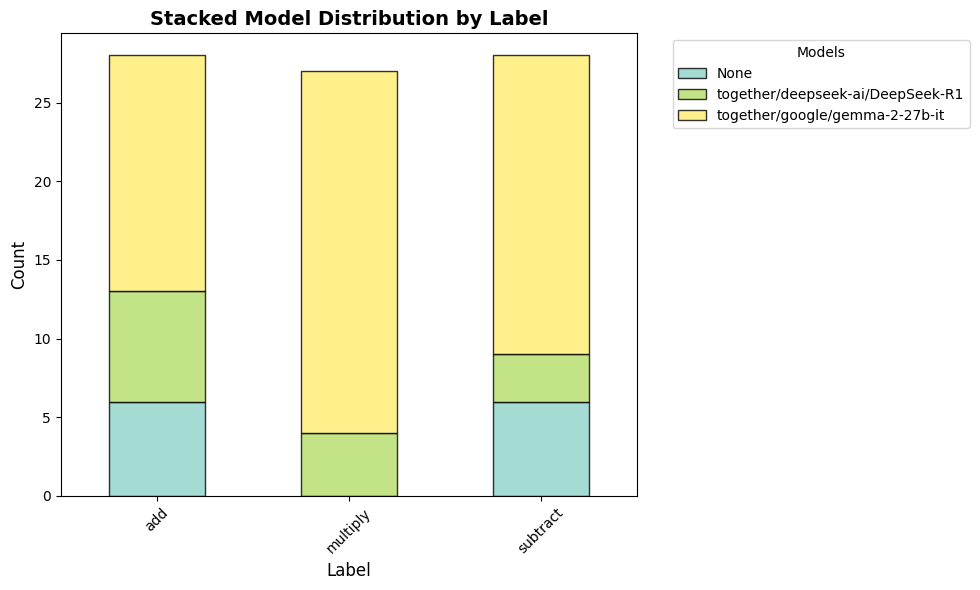

In [71]:
#cleaned_df["label"] = test["label"]
fig2, ax2 = plot_model_counts_advanced(cleaned_df, style='stacked', model_col= 'col_0',figsize=(10, 6))
plt.show()